 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 4. Tensorflow basis**
# Homework 2. Tensorflow로 K-Means 구현하기

### _Objective_
1. Tensorflow 을 이용해서 K-Means 알고리즘을 구현합니다.


╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<br>
<br>
## 예제 데이터셋 )

In [2]:
# 예제 데이터셋 준비하기
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
dataset = np.loadtxt("./kmeans_dataset.txt")

--2019-07-18 08:29:16--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.56.4
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.56.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘kmeans_dataset.txt.1’

kmeans_dataset.txt. 100%[===================>]   1.48K  --.-KB/s    in 0s      

2019-07-18 08:29:16 (56.3 MB/s) - ‘kmeans_dataset.txt.1’ saved [1520/1520]



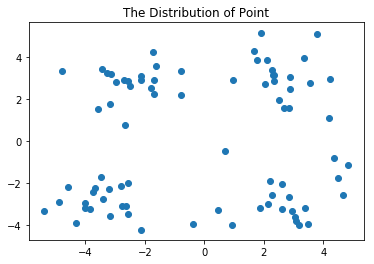

In [3]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1])
plt.show()

<br>
<br>
##  알고리즘 탐색하기
---
K-means의 알고리즘 순서 

1. 초기 중심점을 설정하기 위해 K개의 점 생성(일반적으로 임의)
2. 중심점과 각 데이터 사이의 거리를 계산
3. 각 데이터를 거리가 가장 가까운 군집으로 할당
4. 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
5. 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄

아래 코드는 Numpy 로 K-means 을 구현한 코드 입니다.<br>

---

In [0]:
def cluster_kmeans(dataset, k):    
    # (1) 중심점 초기화
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    
    # (2) ~ (5) 순회
    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point
        
        # (2) 거리 계산
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = np.sqrt((diff_mat**2).sum(axis=-1))
        # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
        cluster_per_point = dists.argmin(axis=0)
        
        # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
    
    return centroids

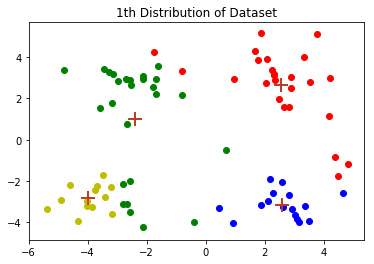

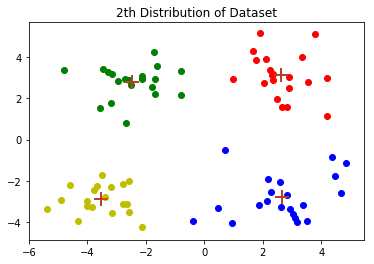

array([[ 2.6265299 ,  3.10868015],
       [-2.46154315,  2.78737555],
       [ 2.65077367, -2.79019029],
       [-3.53973889, -2.89384326]])

In [5]:
cluster_kmeans(dataset, 4)

## \[ 문제 : 텐서플로우를 이용해 K-Means 구현하기 \]

텐서플로우는 numpy와 달리, Dataflow Programming 방식으로 동작합니다. <br>
우선 연산을 결정하고, 반복적인 연산은 Session 시에 진행해야 합니다.<br>



In [6]:
K = 4
graph = tf.Graph()
with graph.as_default():
    xs = tf.constant(dataset, dtype=tf.float32, name='dataset')
    
    # 초기 위치를 결정
    with tf.variable_scope('centroid_intializer'):
        min_f0, min_f1 = tf.split(tf.reduce_min(xs,axis=0), 2)
        max_f0, max_f1 = tf.split(tf.reduce_max(xs,axis=0), 2)
        
        rand_f0 = tf.random.uniform([K], min_f0, max_f0)
        rand_f1 = tf.random.uniform([K], min_f1, max_f1)
        init_centroids = tf.stack([rand_f0, rand_f1], axis=-1)
    centroids = tf.Variable(init_centroids, name='centroids')
    
    # 거리를 계산
    with tf.variable_scope('distance'):
        xsr = tf.expand_dims(xs,1)
        ctr = tf.expand_dims(centroids, 0)
        dists = tf.sqrt(tf.reduce_sum((xsr - ctr)**2, axis=-1))
    
    # 점 위치를 갱신
    with tf.variable_scope('find_new_value'):
        clusters = tf.argmin(dists,1)        
        new_centroids = []
        for c in range(K):
            equal_indices = tf.squeeze(tf.where(tf.equal(clusters, c)))
            new_centroid = tf.reduce_mean(tf.gather(xs,equal_indices),axis=0)
            new_centroids.append(new_centroid)            
        new_centroids = tf.stack(new_centroids,0)
    update_op = tf.assign(centroids, new_centroids,name='update_centroids')
    clusters = tf.identity(clusters, name='clusters')
        

W0718 08:29:18.150616 139698446702464 deprecation.py:323] From <ipython-input-6-9fc2752bd202>:27: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


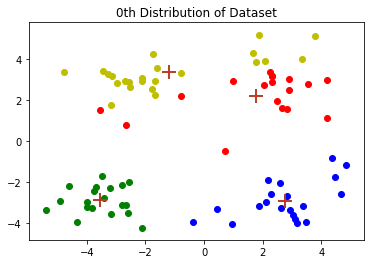

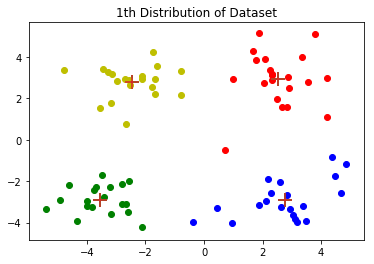

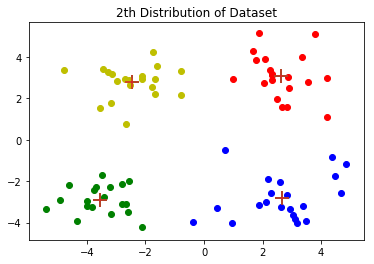

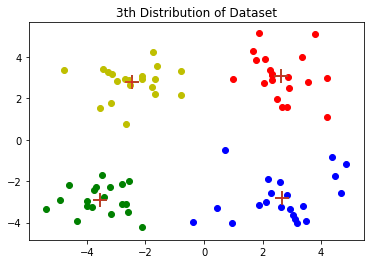

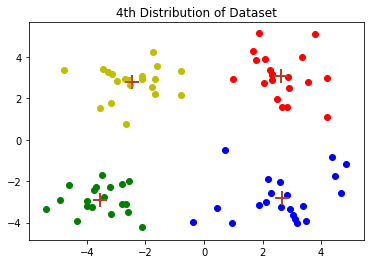

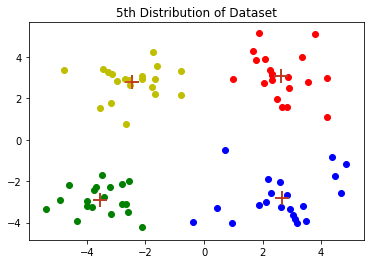

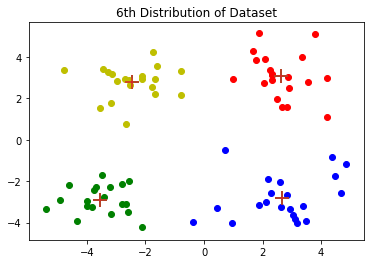

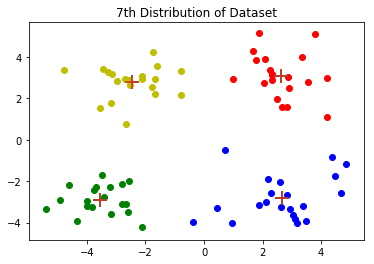

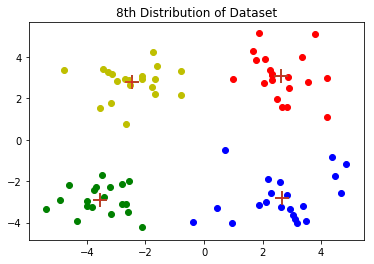

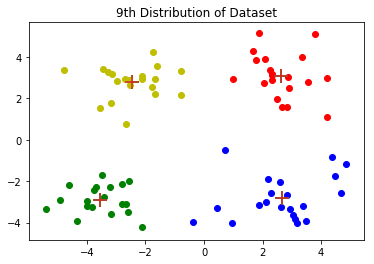

In [7]:
# 아래와 같은 결과가 나오면 됩니다.
with graph.as_default():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    prev_clusters = None
    for step in range(10):
        _, centroid_values, cluster_values = sess.run([update_op, 
                                                       centroids, 
                                                       clusters])
        plt.title("{}th Distribution of Dataset".format(step))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_values==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroid_values[:,0],centroid_values[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
        
        if prev_clusters is None:
            prev_clusters = cluster_values
        elif np.all(prev_clusters==cluster_values):
            break